In [1]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import openml
import datetime

import matplotlib.pyplot as plt

import scipy as sp
import scipy.stats
import numpy as np
import pandas as pd
import itertools as it
from tqdm.notebook import tqdm
import pickle

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

# Preliminaries

## Read Result Data

In [2]:
dfResults = pd.read_csv("results_final.csv")
dfResults

,timeout,openmlid,seed,algorithm,metric
0,85000,1485,0,rf,0.600788
1,85000,1485,0,random,0.373946
2,85000,1590,0,rf,0.570204
3,85000,1485,0,auto-sklearn,0.288015
4,85000,1590,0,random,0.358099
...,...,...,...,...,...
3420,85000,31,7,semi-naive,0.417230
3421,85000,40975,8,semi-naive,0.014152
3422,85000,31,8,naive,0.517943
3423,85000,31,8,semi-naive,0.623437


## Compute metrics to be used for the different datasets

In [3]:
OPTIMIZERS = ["rf", "random", "auto-sklearn", "gama", "naive", "semi-naive"]
OPTIMIZER_COLORS = {"rf": "C4", "random": "C5", "auto-sklearn": "C0", "gama": "C1", "naive": "C2", "semi-naive": "C3"}
OPTIMIZER_NAMES = {"rf": "rf", "random": "random", "auto-sklearn": "auto-sklearn", "gama": "GAMA", "naive": "naive", "semi-naive": "quasi-naive"}

datasets = [int(i) for i in pd.unique(dfResults["openmlid"])]
datasets_sparse = [d for d in [1590, 1486, 4541, 4534, 4135, 40978, 40670, 1111, 42732, 42734, 41162, 41143, 41147, 3, 188, 1461, 42733, 40668] if d in datasets]
#metrics = {1485: 'auc', 1590: 'auc', 1515: 'log_loss', 1457: 'log_loss', 1475: 'log_loss', 1468: 'log_loss', 1486: 'auc', 1489: 'auc', 23512: 'auc', 23517: 'auc', 4541: 'log_loss', 4534: 'auc', 4538: 'log_loss', 4134: 'auc', 4135: 'auc', 40978: 'auc', 40996: 'log_loss', 41027: 'log_loss', 40981: 'auc', 40982: 'log_loss', 40983: 'auc', 40984: 'log_loss', 40701: 'auc', 40670: 'log_loss', 40685: 'log_loss', 40900: 'auc', 1111: 'auc', 42732: 'auc', 42733: 'auc', 42734: 'log_loss', 40498: 'log_loss', 41161: 'auc', 41162: 'auc', 41163: 'log_loss', 41164: 'log_loss', 41165: 'log_loss', 41166: 'log_loss', 41167: 'log_loss', 41168: 'log_loss', 41169: 'log_loss', 41142: 'auc', 41143: 'auc', 41144: 'auc', 41145: 'auc', 41146: 'auc', 41147: 'auc', 41150: 'auc', 41156: 'auc', 41157: 'auc', 41158: 'auc', 41159: 'auc', 41138: 'auc', 54: 'log_loss', 181: 'log_loss', 188: 'log_loss', 1461: 'auc', 1494: 'auc', 1464: 'auc', 12: 'log_loss', 23: 'log_loss', 3: 'auc', 1487: 'auc', 40668: 'log_loss', 1067: 'auc', 1049: 'auc', 40975: 'log_loss', 31: 'auc'}
metrics = {i: "log_loss" for i in datasets}
datasetnames = {1485: 'madelon', 1590: 'adult', 1515: 'micro-mass', 1457: 'amazon-commerce-reviews', 1475: 'first-order-theorem-proving', 1468: 'cnae-9', 1486: 'nomao', 1489: 'phoneme', 23512: 'higgs', 23517: 'numerai28.6', 4541: 'Diabetes130US', 4534: 'PhishingWebsites', 4538: 'GesturePhaseSegmentationProcessed', 4134: 'Bioresponse', 4135: 'Amazon_employee_access', 40978: 'Internet-Advertisements', 40996: 'Fashion-MNIST', 41027: 'jungle_chess_2pcs_raw_endgame_complete', 40981: 'Australian', 40982: 'steel-plates-fault', 40983: 'wilt', 40984: 'segment', 40701: 'churn', 40670: 'dna', 40685: 'shuttle', 40900: 'Satellite', 1111: 'KDDCup09_appetency', 42732: 'sf-police-incidents', 42733: 'Click_prediction_small', 42734: 'okcupid-stem', 40498: 'wine-quality-white', 41161: 'riccardo', 41162: 'kick', 41163: 'dilbert', 41164: 'fabert', 41165: 'robert', 41166: 'volkert', 41167: 'dionis', 41168: 'jannis', 41169: 'helena', 41142: 'christine', 41143: 'jasmine', 41144: 'madeline', 41145: 'philippine', 41146: 'sylvine', 41147: 'albert', 41150: 'MiniBooNE', 41156: 'ada', 41157: 'arcene', 41158: 'gina', 41159: 'guillermo', 41138: 'APSFailure', 54: 'vehicle', 181: 'yeast', 188: 'eucalyptus', 1461: 'bank-marketing', 1494: 'qsar-biodeg', 1464: 'blood-transfusion-service-center', 12: 'mfeat-factors', 23: 'cmc', 3: 'kr-vs-kp', 1487: 'ozone-level-8hr', 40668: 'connect-4', 1067: 'kc1', 1049: 'pc4', 40975: 'car', 31: 'credit-g'}
datasets_auc = [i for i, metric in metrics.items() if metric == "auc"]
datasets_logloss = [i for i, metric in metrics.items() if metric == "log_loss"]

## Compute Performance Curves (those for 1h are derived from that for 1d)

In [4]:
with open('performancecurves.pickle', 'rb') as handle:
    performance_curves_1d = pickle.load(handle)
    for openmlid, curves_on_dataset in performance_curves_1d.items():
        for algo, curves_for_algo_on_dataset in curves_on_dataset.items():
            times = curves_for_algo_on_dataset["times"]
            if times[-1] != 85000:
                raise Exception(f"Last timestamp on curve of {algo} on dataset {openmlid} is not 85000 but {times[-1]}")
            times_recovered = sorted(list(set(times)))
            if len(times) != len(times_recovered) or any([times[i] != t for i, t in enumerate(times_recovered)]):
                raise Exception(f"Times for algo {algo} on dataset {openmlid} are ill formated: {times}")
    
TIME_LIMIT_HOUR = 3600
TIME_LIMIT_DAY = 85000

In [5]:
alarms = []
for timeout in [TIME_LIMIT_DAY]:
    for openmlid in datasets:
        for algo in OPTIMIZERS:
            cnt = len(dfResults[(dfResults["timeout"] == timeout) & (dfResults["algorithm"] == algo) & (dfResults["openmlid"] == openmlid)])
            if cnt < 2:
                print("Alarm for ", algo + " on " + str(openmlid) + " for timeout " + str(timeout) + ":", cnt)

In [6]:
performance_curves_1h = {}
for openmlid in performance_curves_1d:
    performance_curves_1h[openmlid] = {}
    for algo in performance_curves_1d[openmlid]:
        performance_curves_1h[openmlid][algo] = {}
        if "times" in performance_curves_1d[openmlid][algo]:
            matches = np.where(performance_curves_1d[openmlid][algo]["times"] <= 3600)[0]
            if len(matches) > 0:
                cutoff_index = matches[-1]
                performance_curves_1h[openmlid][algo]["times"] = performance_curves_1d[openmlid][algo]["times"][:cutoff_index]
                performance_curves_1h[openmlid][algo]["values"] = performance_curves_1d[openmlid][algo]["values"][:cutoff_index]

# Result Visualizations In Main Paper

## Avg Rank Plots Over Time and Final Performances

In [8]:
def get_rank_curves(performance_curves_per_dataset):
    
    # get all algorithms and times
    algos = None
    times = set([])
    for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
        algos_here = set(performance_curves_of_dataset.keys())
        if algos is None:
            algos = algos_here
        elif algos != algos_here:
            raise Exception("Inconsistent algorithm set! Current is " + str(algos) + " but local is " + str(algos_here))
        for algo, curve in performance_curves_of_dataset.items():
            if not "times" in curve:
                print(f"Empty curve set for dataset {openmlid} on algorithm {algo}")
                continue
            for t in curve["times"]:
                times.add(t)
    if algos is None:
        raise Exception("No algorithms observed ...")
    times = sorted(list(times))
    algos = sorted(list(algos))
    
    # now create average rank score for each point in time
    cur_vals_per_dataset = {openmlid: {algo: np.inf for algo in algos} for openmlid in performance_curves_per_dataset.keys()}
    mean_rank_curves = []
    q1_rank_curves = []
    q3_rank_curves = []
    for t in tqdm(times):
        ranks_at_t = []
        for openmlid, performance_curves_of_dataset in performance_curves_per_dataset.items():
            cur_vals = cur_vals_per_dataset[openmlid]
            considered_algos_for_timestep_and_dataset = []
            for algorithm, curve in performance_curves_of_dataset.items():
                if not "times" in curve:
                    print(f"Empty curve set for dataset {openmlid} and algorithm {algorithm}")
                    continue
                considered_algos_for_timestep_and_dataset.append(algorithm)
                if t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    cur_vals[algorithm] = scipy.stats.trim_mean(np.round(curve["values"][index_of_timestamp], 2), 0.1)
            
            # only consider this time step if all values are available
            if len(considered_algos_for_timestep_and_dataset) == len(algos):
                ranks_at_t.append(list(scipy.stats.rankdata(np.array([cur_vals[algo] for algo in algos]))))
                
        mean_rank_curves.append(list(np.mean(np.array(ranks_at_t), axis=0)))
        q1_rank_curves.append(list(np.percentile(np.array(ranks_at_t), 25, axis=0)))
        q3_rank_curves.append(list(np.percentile(np.array(ranks_at_t), 75, axis=0)))
    return algos, times, np.array(mean_rank_curves), np.array(q1_rank_curves), np.array(q3_rank_curves)

def plot_ranks(avg_rank_curves, ax, algorithm_order = None, log_scale = True, error_bars = True):
    algos = avg_rank_curves[0] if algorithm_order is None else algorithm_order
    times = avg_rank_curves[1]
    mean_curves = avg_rank_curves[2]
    q1_curves = avg_rank_curves[3]
    q3_curves = avg_rank_curves[4]
    
    for algo in algos:
        index = avg_rank_curves[0].index(algo)
        ax.plot(times, mean_curves[:,index], color=OPTIMIZER_COLORS[algo], label=OPTIMIZER_NAMES[algo])
        if error_bars:
            ax.fill_between(times, q1_curves[:,index], q3_curves[:,index], alpha=0.1)
    #ax.legend()
    ax.set_ylim([1, len(algos)])
    if log_scale:
        ax.set_xlim([100, times[-1] + 300])
        ax.set_xscale("log")

In [9]:
def get_final_results(df, timeout):
    df = df[df["timeout"] == timeout]
    algos = list(pd.unique(df["algorithm"]))
    
    results = {}
    
    for openmlid, dfDataset in df.groupby("openmlid"):
        metric = metrics[openmlid]
        if not metric in results:
            results[metric] = {}
        results[metric][openmlid] = {}
        for algo in algos:
            results[metric][openmlid][algo] = dfDataset[dfDataset["algorithm"] == algo]["metric"].values
            
    return results

def plot_final_results_as_boxplot_per_dataset(results, ax_auc, ax_logloss):
    
    from pylab import setp
    
    for metric in ["auc", "log_loss"]:
        for openmlid in results[metric]:
            boxplots = []
            labels = []
            for algo in results[metric][openmlid]:
                boxplots.append(results[metric][openmlid][algo])
                labels.append(OPTIMIZER_NAMES[algo])
            fig, ax = plt.subplots()
            ax.boxplot(boxplots)
            ax.set_title(str(openmlid) + " (" + metric + ")")
            ax.set_xticklabels(labels)
            plt.show()

def plot_final_results_as_rank_boxplot(results, algos, ax):
    
    all_ranks = []
    for metric in ["auc", "log_loss"]:
        if metric in results:
            for openmlid in results[metric]:
                scores = []
                for algo in algos:
                    score = np.nanmedian(results[metric][openmlid][algo])
                    score = np.round(score, 2)# if metric == "auc" else 1)
                    scores.append(score)

                data_to_rank = np.array(scores) if metric is "log_loss" else -np.array(scores)
                ranks = list(scipy.stats.rankdata(data_to_rank))
                all_ranks.append(ranks)
        else:
            print(f"Warning, there is no entry for metric {metric}, ignoring it.")
                
        
    # create plot
    ax.violinplot(np.array(all_ranks), showmedians=True)
    ax.set_xticks(range(1, 1 + len(algos)))
    ax.set_xticklabels([OPTIMIZER_NAMES[a] for a in algos])
        
def plot_final_results_as_rank_boxplot_per_metric(results, ax_auc, ax_logloss):
    
    from pylab import setp
    
    for metric in ["auc", "log_loss"]:
        all_ranks = []
        algos = None
        if metric in results:
            for openmlid in results[metric]:
                scores = []
                algos_here = []
                for algo in results[metric][openmlid]:
                    score = np.nanmedian(results[metric][openmlid][algo])
                    score = np.round(score, 2)
                    scores.append(score)
                    algos_here.append(algo)
                if algos is None:
                    algos = algos_here
                elif algos != algos_here:
                    raise Exception("Inconsistent algorithm order!")

                data_to_rank = np.array(scores) if metric is "log_loss" else -np.array(scores)
                ranks = list(scipy.stats.rankdata(data_to_rank))
                all_ranks.append(ranks)
        else:
            print(f"Warning, there is no entry for metric {metric}, ignoring it.")
        
        # create plot
        ax = ax_auc if metric == "auc" else ax_logloss
        ax.violinplot(np.array(all_ranks))
        ax.set_title(metric)
        ax.set_xticks(range(1, 1 + len(algos)))
        ax.set_xticklabels([OPTIMIZER_NAMES[a] for a in algos])
        
def get_plot_ofrank_curves_and_violines(avg_rank_curves, algorithm_order, df, timeout, log_scale):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    plot_ranks(avg_rank_curves, ax1, algorithm_order=algorithm_order, log_scale=log_scale)
    ax1.set_ylabel("Validation Rank")
    ax1.set_xlabel("Runtime (s)")
    plot_final_results_as_rank_boxplot(get_final_results(df[df["algorithm"].isin(algorithm_order)], timeout), algorithm_order, ax2)
    ax2.set_ylabel("Test Rank")
    fig.tight_layout()
    return fig, (ax1, ax2)
    

In [10]:
def get_algos_and_times_for_curveset(curveset):
    
    # get all algorithms and times
    algos = None
    times = set([])
    for openmlid, performance_curves_of_dataset in curveset.items():
        algos_here = set(performance_curves_of_dataset.keys())
        if algos is None:
            algos = algos_here
        elif algos != algos_here:
            raise Exception("Inconsistent algorithm set! Current is " + str(algos) + " but local is " + str(algos_here))
        for curve in performance_curves_of_dataset.values():
            if not "times" in curve:
                print(f"Empty curve set for dataset {openmlid}")
                continue
            for t in curve["times"]:
                times.add(t)
                
    if algos is None:
        raise Exception(f"No algorithms observed in curveset {curveset}")
    times = sorted(list(times))
    algos = sorted(list(algos))
    return algos, times

def get_empirical_gaps_over_time(performance_curves):
    
    curves_for_auc = performance_curves
    algos, times = get_algos_and_times_for_curveset(curves_for_auc)
    datasets = curves_for_auc.keys()
    
    cur_vals_per_dataset = {openmlid: {algo: np.inf for algo in algos} for openmlid in datasets}
    sup_curves = {openmlid: [] for openmlid in datasets}
    values = {algo: [] for algo in algos}
    
    for t_index, t in enumerate(tqdm(times)):
        gaps_at_t = {}
        for openmlid, performance_curves_of_dataset in curves_for_auc.items():
            cur_vals = cur_vals_per_dataset[openmlid]
            for algorithm, curve in performance_curves_of_dataset.items():
                if "times" in curve and t in curve["times"]:
                    index_of_timestamp = np.where(curve["times"] == t)[0][0]
                    cur_vals[algorithm] = np.median(curve["values"][index_of_timestamp])
            
            best_value_at_t = min(cur_vals.values())
            gaps_at_t[openmlid] = {algorithm: min(1, cur_vals[algorithm] - best_value_at_t) if best_value_at_t < np.inf else 0 for algorithm in algos}
            sup_curves[openmlid].append(best_value_at_t)
            
        for algo in algos:
            gaps_of_algo_at_time = [gaps_at_t[openmlid][algo] for openmlid in datasets]
            values[algo].append(gaps_of_algo_at_time)
            
    return times, values

def plot_empirical_gaps_over_time(empirical_gaps, ax, time_normalizer = 1):
    times, values = empirical_gaps
    for algo, curves_of_algo in values.items():
        color = OPTIMIZER_COLORS[algo]
        ax.step(times, np.mean(curves_of_algo, axis=1),  label=OPTIMIZER_NAMES[algo], color=color, linewidth=1)
        #ax.step(times, np.percentile(curves_of_algo, 95, axis=1), linestyle="dotted", color=color, linewidth=1)
        #ax.step(times, np.percentile(curves_of_algo, 75, axis=1), linestyle="--", color=color, linewidth=1)
        #ax.fill_between(times, np.percentile(curves_of_algo, 25, axis=1), np.percentile(curves_of_algo, 75, axis=1), color=color, alpha=0.1)

## Compute All Curves

In [11]:
%%time
rank_curves_1h = get_rank_curves(performance_curves_1h)
rank_curves_1d = get_rank_curves(performance_curves_1d)

Empty curve set for dataset 42732 on algorithm rf


  0%|          | 0/9640 [00:00<?, ?it/s]

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 42732 and algorithm rf
Empty curve set for dataset 427

  0%|          | 0/18744 [00:00<?, ?it/s]

CPU times: user 3min 16s, sys: 4.53 s, total: 3min 21s
Wall time: 3min 15s


In [12]:
%%time
empirical_gaps_1h = get_empirical_gaps_over_time(performance_curves_1h)
empirical_gaps_1d = get_empirical_gaps_over_time(performance_curves_1d)

Empty curve set for dataset 42732


  0%|          | 0/9640 [00:00<?, ?it/s]

  0%|          | 0/18744 [00:00<?, ?it/s]

CPU times: user 58.7 s, sys: 2.16 s, total: 1min
Wall time: 58.5 s


## Create Plots

### 1h Time Limit

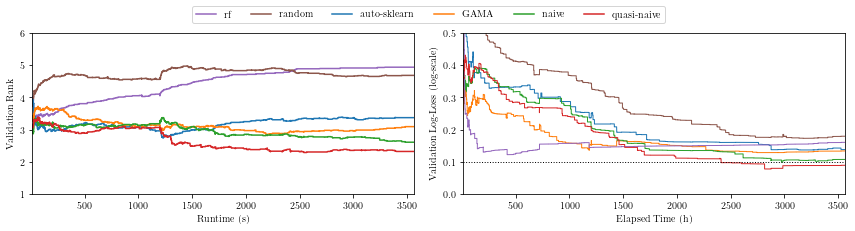

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# left plot: ranks
plot_ranks(rank_curves_1h, ax1, algorithm_order=OPTIMIZERS, log_scale=False, error_bars = False)
ax1.set_ylabel("Validation Rank")
ax1.set_xlim([10, TIME_LIMIT_HOUR * .99])
ax1.set_xlabel("Runtime (s)")

# right plot: empirical gaps
plot_empirical_gaps_over_time(empirical_gaps_1h, ax2)
ax2.set_ylabel("Validation Log-Loss (log-scale)")
ax2.set_xlabel("Elapsed Time (h)")
ax2.set_ylim([0, .5])
ax2.axhline(0.1, linestyle="dotted", color="black", linewidth=1)
ax2.set_xlim([10, TIME_LIMIT_HOUR * .99])

# create legend
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=6)

fig.tight_layout()
fig.savefig("plots/ranks-1h.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

### 1d Time Limit

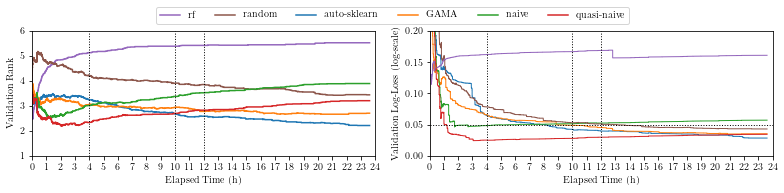

CPU times: user 2.32 s, sys: 675 ms, total: 2.99 s
Wall time: 1.83 s


In [14]:
%%time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 2.5))

# left plot: ranks
plot_ranks(rank_curves_1d, ax1, algorithm_order=OPTIMIZERS, log_scale=False, error_bars = False)
ax1.set_ylabel("Validation Rank")
ax1.axvline(3600 * 4, linestyle="dotted", linewidth=1, color="black")
ax1.axvline(3600 * 10, linestyle="dotted", linewidth=1, color="black")
ax1.axvline(3600 * 12, linestyle="dotted", linewidth=1, color="black")

# right plot: empirical gaps
plot_empirical_gaps_over_time(empirical_gaps_1d, ax2)
ax2.set_ylabel("Validation Log-Loss (log-scale)")
ax2.set_ylim([0, .2])
ax2.axvline(3600 * 4, linestyle="dotted", linewidth=1, color="black")
ax2.axvline(3600 * 10, linestyle="dotted", linewidth=1, color="black")
ax2.axvline(3600 * 12, linestyle="dotted", linewidth=1, color="black")
ax2.axhline(0.05, linestyle="dotted", color="black", linewidth=1)
ax2.set_xlim([10, TIME_LIMIT_DAY])

for a in [ax1, ax2]:
    a.set_xlim([10, TIME_LIMIT_DAY])
    a.set_xticks(range(0, 24 * 3600 + 1, 3600))
    a.set_xticklabels(range(0, 25))
    a.set_xlabel("Elapsed Time (h)")

# create legend
handles, labels = ax1.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=6)

fig.tight_layout()
fig.savefig("plots/ranks-1d.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Test Performance Gaps to Best (Only for 1d)

In [15]:
def get_optimality_gaps(df):
    gaps = {}
    for openmlid, dfDataset in df.groupby("openmlid"):
        is_max = metrics[openmlid] == "auc"
        medians = {algorithm: np.nanmedian(dfAlgo["metric"].values) for algorithm, dfAlgo in dfDataset.groupby("algorithm")}
        best_median = max(medians.values()) if is_max else min(medians.values())
        gaps_on_dataset = {algo: best_median - median if is_max else median - best_median for algo, median in medians.items()}
        gaps[openmlid] = gaps_on_dataset
    return gaps

def get_gap_plot_for_computed_gaps(gaps, ax):
    
    if len(gaps) == 0:
        return
    
    # compute gaps per algorithm
    gaps_per_algorithm = {}
    for openmlid, gaps_for_dataset in gaps.items():        
        for algo, gap in gaps_for_dataset.items():
            if not algo in gaps_per_algorithm:
                gaps_per_algorithm[algo] = []
            gaps_per_algorithm[algo].append(gap)
    
    # create violinplot
    algos = OPTIMIZERS
    ax.violinplot([gaps_per_algorithm[algo] for algo in algos], showmedians=True, quantiles=[[.5, .9] for i in range(len(algos))])
    ax.set_xticks(range(1, len(algos) + 1))
    ax.set_xticklabels([OPTIMIZER_NAMES[a] for a in algos])
    

def get_gap_plots(df, timeout):    
    fig, ax = plt.subplots(1, 2, figsize=(15, 3))
    gaps = get_optimality_gaps(df[dfResults["timeout"] == timeout])
    gaps_for_auc = {openmlid: gaps_of_id for openmlid, gaps_of_id in gaps.items() if metrics[openmlid] == "auc"}
    get_gap_plot_for_computed_gaps(gaps_for_auc, ax[0])
    ax[0].set_ylim([0, 0.1])
    ax[0].set_title("Gaps on AUROC datasets")
    gaps_for_log_loss = {openmlid: gaps_of_id for openmlid, gaps_of_id in gaps.items() if metrics[openmlid] == "log_loss"}
    get_gap_plot_for_computed_gaps(gaps_for_log_loss, ax[1])
    ax[1].set_ylim([0, .2])
    ax[1].set_title("Gaps on log-loss datasets")
    return fig, ax

Warning, there is no entry for metric auc, ignoring it.


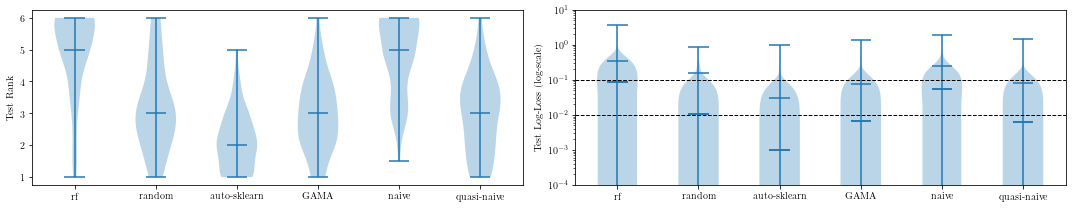

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 3))
gaps = get_optimality_gaps(dfResults[dfResults["timeout"] == TIME_LIMIT_DAY])

# rank gaps
plot_final_results_as_rank_boxplot(get_final_results(dfResults[dfResults["algorithm"].isin(OPTIMIZERS)], TIME_LIMIT_DAY), OPTIMIZERS, ax[0])
ax[0].set_ylabel("Test Rank")

# absolute gaps
get_gap_plot_for_computed_gaps(gaps, ax[1])
ax[1].set_ylim([10**-4, 10.0])
ax[1].set_yscale("log")
ax[1].set_ylabel("Test Log-Loss (log-scale)")
ax[1].axhline(0.1, linestyle="--", linewidth=1, color="black")
ax[1].axhline(0.01, linestyle="--", linewidth=1, color="black")

fig.tight_layout()
fig.savefig("plots/gaps-1d.pdf")
plt.show()

In [17]:
print(np.percentile([v["semi-naive"] for k,v in gaps.items()], 80))

0.040068094188634405


## Grid Search Results
These results are used to compare with the best algorithm selection possible.

In [18]:
import json

In [19]:
dfGrid = pd.read_csv("gridsearchresults.csv", delimiter=";")
dfGrid = dfGrid[(dfGrid["exception"].isna()) & (dfGrid["metric"].notna())]
dfGrid

,experiment_id,openmlid,seed,algorithm,timeout_total,timeout_evaluation,cpus,memory_max,time_created,host,executor,time_started,chosenmodel,errorrate,metric,onlinedata,exception,time_end
0,5123,3,1,grid,85000,1200,2,24000,2021-12-14 21:55:30,node09-037,oculus-9875192-168,2021-12-17 10:29:30,"Pipeline(steps=[('data-pre-processor', Varianc...",0.003125,0.009296,"[[1.7011158466339111, ""Pipeline(steps=[('class...",NaN,2021-12-17 11:06:31
1,5130,3,2,grid,85000,1200,2,24000,2021-12-14 21:55:30,node03-008,oculus-9875192-177,2021-12-17 05:53:41,"Pipeline(steps=[('classifier',\n ...",0.003125,0.012337,"[[1.908933401107788, ""Pipeline(steps=[('classi...",NaN,2021-12-17 06:30:50
2,5143,3,3,grid,85000,1200,2,24000,2021-12-14 21:55:30,node03-026,oculus-9875192-191,2021-12-17 05:04:50,"Pipeline(steps=[('data-pre-processor', Quantil...",0.000000,0.004106,"[[1.6672570705413818, ""Pipeline(steps=[('class...",NaN,2021-12-17 05:42:24
3,5150,3,4,grid,85000,1200,2,24000,2021-12-14 21:55:30,node02-016,oculus-9875192-151,2021-12-17 13:27:24,"Pipeline(steps=[('feature-pre-processor', Poly...",0.003125,0.004707,"[[1.7069385051727295, ""Pipeline(steps=[('class...",NaN,2021-12-17 14:05:20
4,5155,3,5,grid,85000,1200,2,24000,2021-12-14 21:55:30,node03-009,oculus-9875192-176,2021-12-17 10:52:25,"Pipeline(steps=[('data-pre-processor', Quantil...",0.003125,0.013707,"[[1.6865899562835693, ""Pipeline(steps=[('class...",NaN,2021-12-17 11:29:03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,4914,42734,6,grid,85000,1200,2,24000,2021-12-14 21:55:30,node02-027,oculus-9875192-20,2021-12-16 00:09:35,"Pipeline(steps=[('data-pre-processor', Normali...",0.254971,0.589842,"[[2.386615753173828, ""Pipeline(steps=[('classi...",NaN,2021-12-16 07:33:55
546,4927,42734,7,grid,85000,1200,2,24000,2021-12-14 21:55:30,node05-023,oculus-9898210-12,2021-12-22 02:23:21,"Pipeline(steps=[('data-pre-processor', Normali...",0.251821,0.595430,"[[1.8796682357788086, ""Pipeline(steps=[('class...",NaN,2021-12-22 11:51:05
547,4936,42734,8,grid,85000,1200,2,24000,2021-12-14 21:55:30,node05-014,oculus-9875192-90,2021-12-16 00:09:38,"Pipeline(steps=[('data-pre-processor', Normali...",0.252412,0.584750,"[[2.372054100036621, ""Pipeline(steps=[('classi...",NaN,2021-12-16 07:36:07
548,4945,42734,9,grid,85000,1200,2,24000,2021-12-14 21:55:30,node07-004,oculus-9898210-8,2021-12-21 22:08:03,"Pipeline(steps=[('data-pre-processor', Normali...",0.259106,0.601450,"[[2.0698254108428955, ""Pipeline(steps=[('class...",NaN,2021-12-22 08:01:01


In [20]:
from util import *

In [33]:
eps = 0.03
datasets_stripe = [d for d in sorted(datasets) if d not in [41150, 41158, 41168]]

def get_code(algo):
    return str(algo) if algo.__class__ == sklearn.svm.SVC else str(algo.__class__)

hits = np.zeros((3, len(datasets_stripe)))
misses = np.zeros((3, len(datasets_stripe)))
for i, row in tqdm(dfGrid.iterrows()):
    
    if not row["openmlid"] in datasets_stripe:
        continue
    
    col_index = datasets_stripe.index(row["openmlid"])
    
    history = json.loads(row["onlinedata"])
    augmented_history = [(e[0], recover_pipeline(e[1]), e[2]["neg_log_loss"]) for e in history]
    
    # find best score in grid
    best_score = max([e[2]["neg_log_loss"] for e in history])
    eps_best_entries = [e for e in augmented_history if e[2] >= best_score - eps]
    
    # compute acceptable choice for each slot
    acceptable_choices = {}
    for time, pl, score in eps_best_entries:
        for step in ["data-pre-processor", "feature-pre-processor", "classifier"]:
            if not step in acceptable_choices:
                acceptable_choices[step] = set()
            
            if step in [s[0] for s in pl.steps]:
                acceptable_choices[step].add(get_code(pl[step]))
            else:
                acceptable_choices[step].add(None)
    
    # now check whether a greedy search would have chosen the correct classifier
    classifier_only_entries = [e for e in augmented_history if len(e[1].steps) == 1 and not np.isnan(e[2])]
    best_classifier_only_entry = classifier_only_entries[np.argmax([e[2] for e in classifier_only_entries])]
    best_classifier = best_classifier_only_entry[1]["classifier"]
    best_classifier_code = get_code(best_classifier)
    if best_classifier_code in acceptable_choices["classifier"]:
        hits[0,col_index] += 1
    else:
        misses[0,col_index] += 1
    
    # now check whether a greedy search would have chosen the correct data-pre-processor
    two_step_pipelines = [e for e in augmented_history if len(e[1].steps) == 2 and get_code(e[1]["classifier"]) == best_classifier_code and 'data-pre-processor' in [s[0] for s in e[1].steps] and not np.isnan(e[2])]
    if two_step_pipelines:
        chosen_two_step_entry = two_step_pipelines[np.argmax([e[2] for e in two_step_pipelines])]
        if chosen_two_step_entry[2] > best_classifier_only_entry[2]:
            chosen_data_preprocessor = get_code(chosen_two_step_entry[1]["data-pre-processor"])
        else:
            chosen_data_preprocessor = None
    else:
        chosen_data_preprocessor = None
    hit = chosen_data_preprocessor in acceptable_choices["data-pre-processor"]
    if hit:
        hits[1,col_index] += 1
    else:
        misses[1,col_index] += 1
    
    # now check whether a greedy search would have chosen the correct feature-pre-processor
    if chosen_data_preprocessor is None:
        complete_pipelines = [e for e in augmented_history if len(e[1].steps) == 2 and str(e[1]["classifier"]) == str(best_classifier) and 'feature-pre-processor' in [s[0] for s in e[1].steps] and not np.isnan(e[2])]
    else:
        complete_pipelines = [e for e in augmented_history if len(e[1].steps) == 3 and str(e[1]["classifier"]) == str(best_classifier) and get_code(e[1]["data-pre-processor"]) == chosen_data_preprocessor and not np.isnan(e[2])]
    best_full_entry = complete_pipelines[np.argmax([e[2] for e in complete_pipelines])] if complete_pipelines else None
    if best_full_entry is not None and best_full_entry[2] > max(chosen_two_step_entry[2], best_classifier_only_entry[2]):
        chosen_feature_preprocessor = get_code(best_full_entry[1]["feature-pre-processor"])
    else:
        chosen_feature_preprocessor = None
    hit = chosen_feature_preprocessor in acceptable_choices["feature-pre-processor"]
    if hit:
        hits[2,col_index] += 1
    else:
        misses[2,col_index] += 1

0it [00:00, ?it/s]

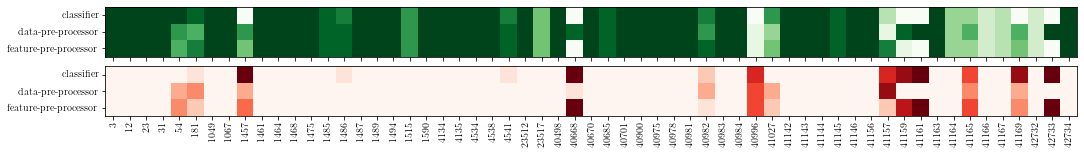

In [34]:
plot_progress = False


fig, ax = plt.subplots(2 + plot_progress, 1, figsize=(20, 2 + plot_progress), sharex=True)
ylabels = ["classifier", "data-pre-processor", "feature-pre-processor"]
if plot_progress:
    ax[0].imshow(-(hits + misses), cmap="seismic", vmin=-10, vmax=0)
    ax[0].set_xticks(range(len(datasets_stripe)))
    ax[0].set_xticklabels(datasets_stripe, rotation=90)
    ax[0].set_yticks(range(len(ylabels)))
    ax[0].set_yticklabels(ylabels)

(ax_hit, ax_miss) = ax[-2], ax[-1]

ax_hit.imshow(hits, cmap="Greens", vmin=0, vmax=10)
ax_hit.set_xticks(range(len(datasets_stripe)))
ax_hit.set_xticklabels(datasets_stripe, rotation=90)
ax_hit.set_yticks(range(len(ylabels)))
ax_hit.set_yticklabels(ylabels)

ax_miss.imshow(misses, cmap="Reds", vmin=0, vmax=10)
ax_miss.set_xticks(range(len(datasets_stripe)))
ax_miss.set_xticklabels(datasets_stripe, rotation=90)
ax_miss.set_yticks(range(len(ylabels)))
ax_miss.set_yticklabels(ylabels)

fig.savefig("plots/independence.pdf", bbox_inches='tight')
plt.show()

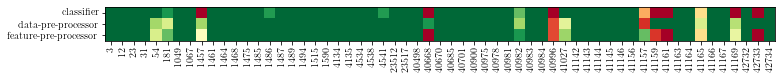

In [35]:
fig, ax = plt.subplots(figsize=(12, 2))
ylabels = ["classifier", "data-pre-processor", "feature-pre-processor"]
ax.imshow(hits / (hits + misses), cmap="RdYlGn", vmin=0, vmax=1)
ax.set_xticks(range(len(datasets_stripe)))
ax.set_xticklabels(datasets_stripe, rotation=90)
ax.set_yticks(range(len(ylabels)))
ax.set_yticklabels(ylabels)

fig.savefig("plots/independence.pdf", bbox_inches='tight')
plt.show()

In [36]:
print(pd.DataFrame(np.column_stack([datasets_stripe, (hits / (hits + misses)).T.round(2)]), columns=["openmlid"] + ylabels).astype({"openmlid": int}).sort_values("openmlid").to_latex(index=False,escape=False))

\begin{tabular}{rrrr}
\toprule
 openmlid &  classifier &  data-pre-processor &  feature-pre-processor \\
\midrule
        3 &        1.00 &                1.00 &                   1.00 \\
       12 &        1.00 &                1.00 &                   1.00 \\
       23 &        1.00 &                1.00 &                   1.00 \\
       31 &        1.00 &                1.00 &                   1.00 \\
       54 &        1.00 &                0.70 &                   0.60 \\
      181 &        0.90 &                0.60 &                   0.80 \\
     1049 &        1.00 &                1.00 &                   1.00 \\
     1067 &        1.00 &                1.00 &                   1.00 \\
     1457 &        0.00 &                0.70 &                   0.50 \\
     1461 &        1.00 &                1.00 &                   1.00 \\
     1464 &        1.00 &                1.00 &                   1.00 \\
     1468 &        1.00 &                1.00 &                   1.00 \

In [37]:
(np.sum(hits) + np.sum(misses)) / (62*10*3)

0.8709677419354839

In [38]:
np.sum(hits) / (np.sum(hits) + np.sum(misses))

0.8814814814814815

# Appendix

## Dataset Descriptions

In [27]:
dfDatasets = pd.read_csv("metadata.csv")
dfDatasets["name"] = [name.replace("_", "\\_")[:20] for name in dfDatasets["name"]]
dfDatasets

,openmlid,in benchmark,name,instances,features,numeric features,classes,min \%,maj \%,\% missing,"\% [0,1]",\% $\mu = 0$,\% $\sigma = 1$
0,3,True,kr-vs-kp,3196,36,0,2,47\%,52\%,0\%,NaN,NaN,NaN
1,12,True,mfeat-factors,2000,216,216,10,10\%,10\%,0\%,0\%,0\%,0\%
2,23,False,cmc,1473,9,2,3,22\%,42\%,0\%,0\%,0\%,0\%
3,31,True,credit-g,1000,20,7,2,30\%,70\%,0\%,0\%,0\%,0\%
4,54,True,vehicle,846,18,18,4,23\%,25\%,0\%,0\%,0\%,0\%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,41168,True,jannis,83733,54,54,4,2\%,46\%,0\%,4\%,0\%,0\%
58,41169,True,helena,65196,27,27,100,0\%,6\%,0\%,4\%,0\%,0\%
59,42732,False,sf-police-incidents,2215023,9,3,2,12\%,87\%,0\%,0\%,0\%,0\%
60,42733,False,Click\_prediction\_s,39948,11,5,2,16\%,83\%,0\%,0\%,0\%,0\%


In [28]:
print(dfDatasets.rename(columns={"openmlid": "id"}).astype({"in benchmark": int}).to_latex(index=False,escape=False))

\begin{tabular}{rrlrrrrllllll}
\toprule
    id &  in benchmark &                  name &  instances &  features &  numeric features &  classes & min \% & maj \% & \% missing & \% [0,1] & \% $\mu = 0$ & \% $\sigma = 1$ \\
\midrule
     3 &             1 &              kr-vs-kp &       3196 &        36 &                 0 &        2 &   47\% &   52\% &        0\% &      NaN &          NaN &             NaN \\
    12 &             1 &         mfeat-factors &       2000 &       216 &               216 &       10 &   10\% &   10\% &        0\% &      0\% &          0\% &             0\% \\
    23 &             0 &                   cmc &       1473 &         9 &                 2 &        3 &   22\% &   42\% &        0\% &      0\% &          0\% &             0\% \\
    31 &             1 &              credit-g &       1000 &        20 &                 7 &        2 &   30\% &   70\% &        0\% &      0\% &          0\% &             0\% \\
    54 &             1 &               vehicle

In [29]:
for col in ["instances", "features", "numeric features", "classes", "min \\%", "maj \\%", "\\% missing"]:
    print(col)
    vals = dfDatasets[col]
    if "%" in col:
        vals = [int(v[:v.index("%") - 1]) for v in dfDatasets[col]]
    print("\tMin:", min(vals))
    print("\tMax:", max(vals))
    print("\tQ1:", np.percentile(vals, 25))
    print("\tQ3:", np.percentile(vals, 75))
    print("\tIQR:", np.percentile(vals, 75) - np.percentile(vals, 25))
    print("\tRange:", max(vals) - min(vals))
    print("\tMean:", np.mean(vals))
    print("\tMedian:", np.median(vals))
    print("\tStd:", np.std(vals))

instances
	Min: 100
	Max: 2215023
	Q1: 2159.25
	Q3: 43601.25
	IQR: 41442.0
	Range: 2214923
	Mean: 63677.596774193546
	Median: 5112.0
	Std: 281595.3970651956
features
	Min: 4
	Max: 10000
	Q1: 18.25
	Q3: 295.75
	IQR: 277.5
	Range: 9996
	Mean: 812.758064516129
	Median: 39.0
	Std: 2068.4556782972472
numeric features
	Min: 0
	Max: 10000
	Q1: 6.0
	Q3: 248.25
	IQR: 242.25
	Range: 10000
	Mean: 777.6935483870968
	Median: 27.0
	Std: 2071.7420407731183
classes
	Min: 2
	Max: 355
	Q1: 2.0
	Q3: 5.75
	IQR: 3.75
	Range: 353
	Mean: 11.85483870967742
	Median: 2.0
	Std: 46.03044111069274
min \%
	Min: 0
	Max: 50
	Q1: 6.25
	Q3: 32.25
	IQR: 26.0
	Range: 50
	Mean: 20.580645161290324
	Median: 14.0
	Std: 17.234201168210483
maj \%
	Min: 0
	Max: 98
	Q1: 35.75
	Q3: 74.0
	IQR: 38.25
	Range: 98
	Mean: 52.903225806451616
	Median: 52.0
	Std: 26.442091126508124
\% missing
	Min: 0
	Max: 15
	Q1: 0.0
	Q3: 0.0
	IQR: 0.0
	Range: 15
	Mean: 0.24193548387096775
	Median: 0.0
	Std: 1.8895765344935453


## Performances Over Time

In [30]:
def plot_performances_over_time(performance_curves, suffix, algorithm_order = None, error_bars = True, min_margin=0.1, focus = "start", ax = None):
    
    def add_curve_to_plot(curve, ax, color, label=None):
        median = np.nanmedian(curve["values"], axis=1)
        mean = np.nanmean(curve["values"], axis=1)
        if error_bars:
            adjusted = np.minimum(10, curve["values"])
            q1 = np.nanpercentile(adjusted, 25, axis=1)
            q3 = np.nanpercentile(adjusted, 75, axis=1)
            ax.fill_between(curve["times"], q1, q3, step="pre", alpha=0.15, color=color)
        ax.step(curve["times"], median, color=color, label=label)
        ax.step(curve["times"], mean, color=color, linestyle="--")
    
    last_timestamps_asklearn = []
    last_timestamps_seminaive = []
    axises = {}
    
    if ax is not None and len(performance_curves) > 1:
        raise Exception("Axis object can only be delivered if there is information for a single dataset!")
    
    for openmlid, curves in performance_curves.items():
        metric = metrics[openmlid]
        best_final_value = max([np.median(c["values"][-1]) if len(c) > 0 and len(c["values"]) > 0 else -np.inf for algo, c in curves.items()])

        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 2))
        else:
            fig = None

        all_median_values = []
        
        algos = curves.keys() if algorithm_order is None else algorithm_order
        
        for algorithm in algos:
            curve = curves[algorithm]
            if not "values" in curve:
                print(f"No curve for algorithm {algorithm}")
                continue
            
            if focus == "start":
                for t, v in zip(curve["times"], curve["values"]):
                    #if not np.isnan(v) and v != -np.inf and v != np.inf:
                    if np.median(v) <= 10 and (t >= 100 or algorithm == "rf"):
                        all_median_values.append(np.median(v))
            elif focus == "end":
                for t, v in zip(curve["times"], curve["values"]):
                    #if not np.isnan(v) and v != -np.inf and v != np.inf:
                    if np.median(v) <= 10 and (t >= 3600 * 4 or algorithm == "rf"):
                        all_median_values.append(np.median(v))
            
            if len(curve["times"]) > 0:
                last_timestamps_asklearn.append(curve["times"][-1])
            
            add_curve_to_plot(curve, ax, OPTIMIZER_COLORS[algorithm], OPTIMIZER_NAMES[algorithm])
        all_median_values = np.array(all_median_values)

        # adjust axis limits
        v_min_theory = 1 if metric == "auc" else 0
        v_min_data = min(all_median_values)# - (0.01 if metric == "auc" else 0.1)
        v_min = max(v_min_theory, v_min_data)
        v_max = max(max(all_median_values[all_median_values < np.inf]), v_min + min_margin)
        if not np.isnan(v_min) and not np.isnan(v_max) and v_max < np.inf and v_min > -np.inf:
            ax.set_ylim([v_min, v_max])
            
        if not fig is None:
            fig.tight_layout()
            fig.savefig("plots/runs/" + str(openmlid) + "_" + suffix + ".pdf")
        axises[openmlid] = ax
    return axises

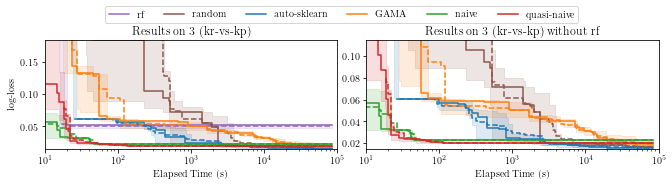

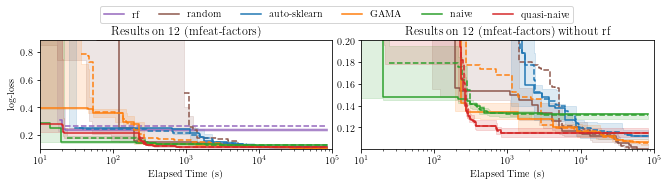

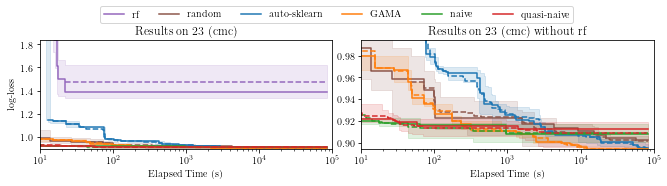

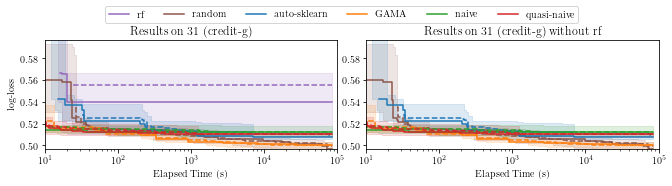

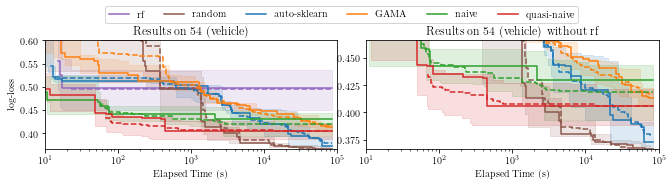

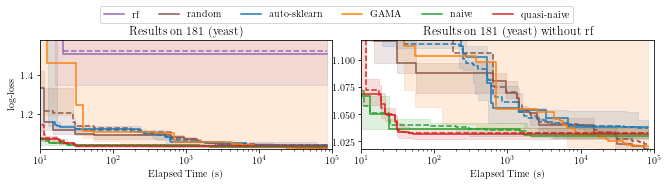

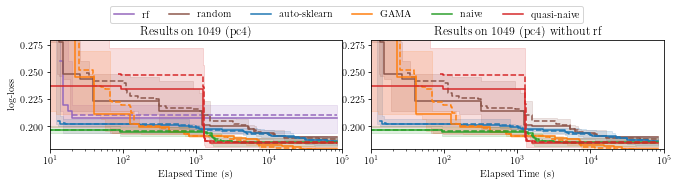

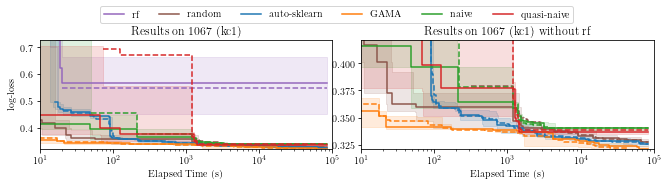

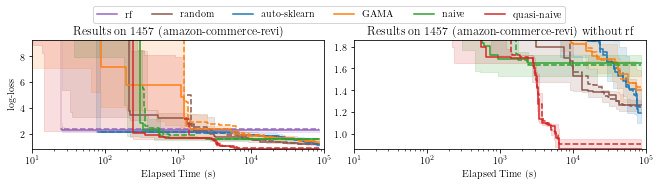

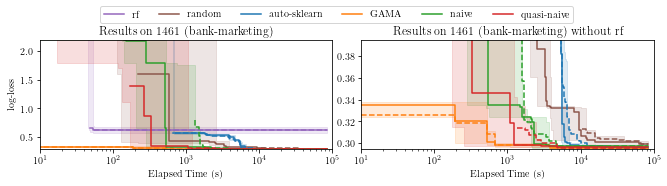

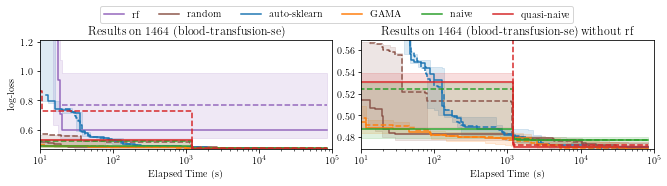

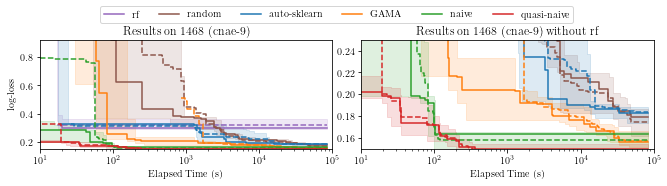

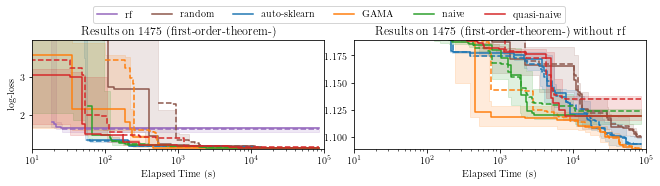

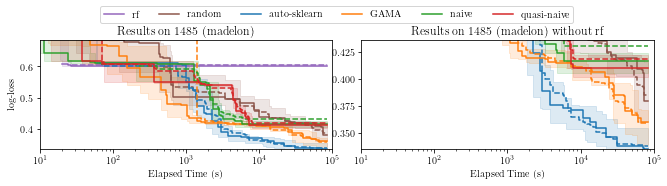

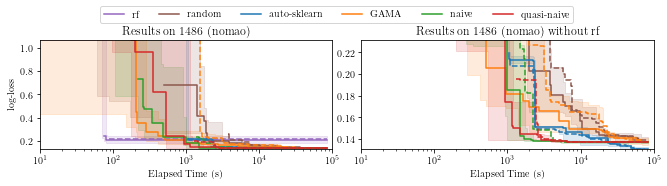

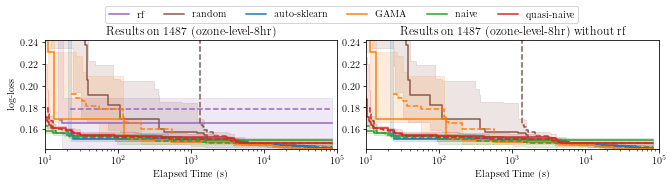

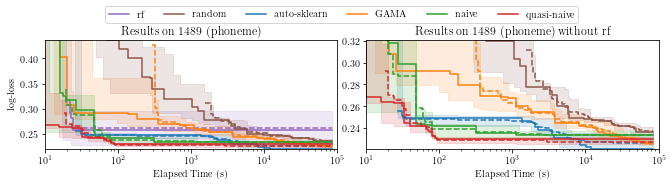

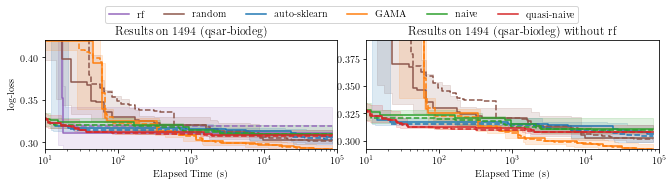

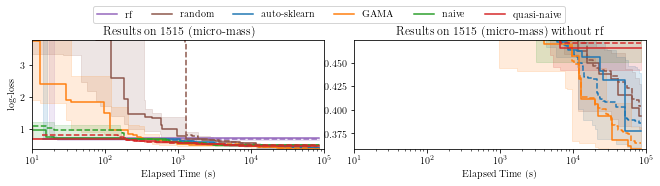

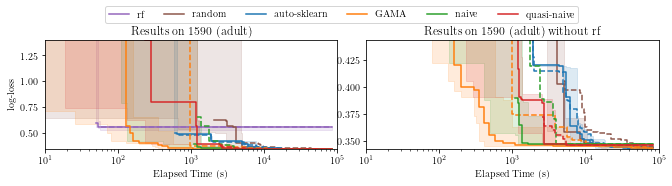

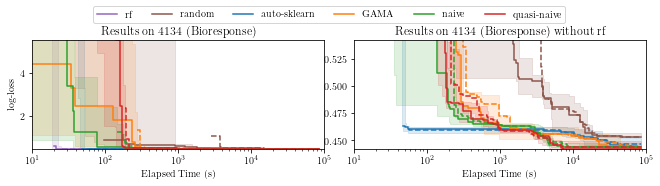

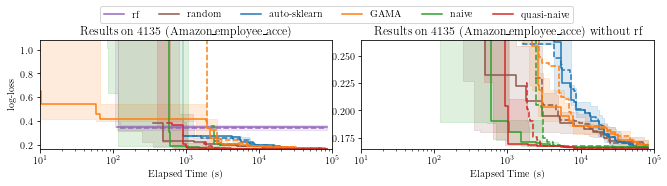

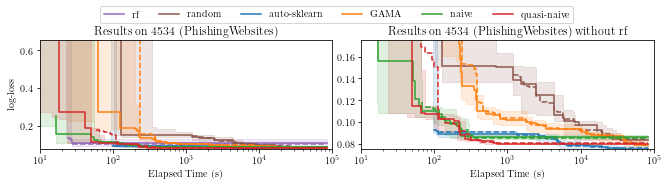

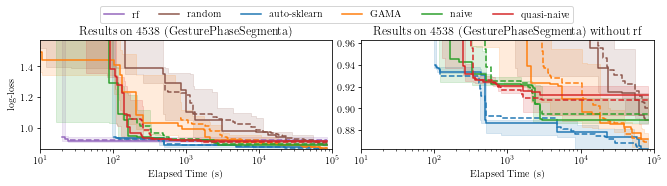

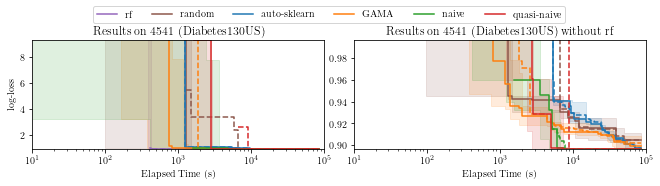

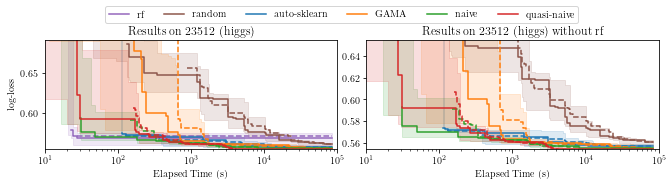

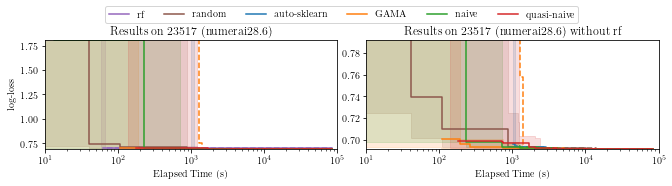

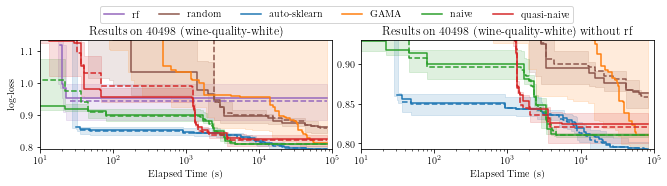

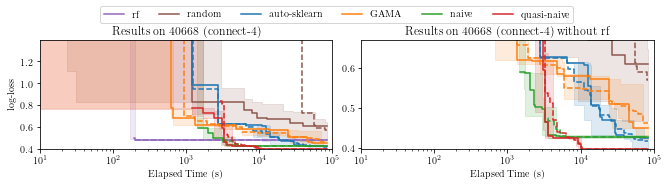

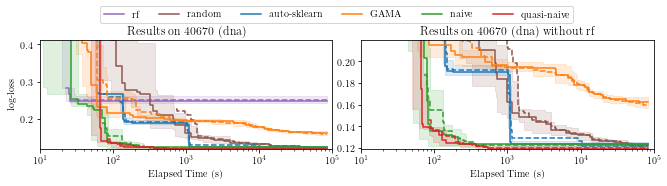

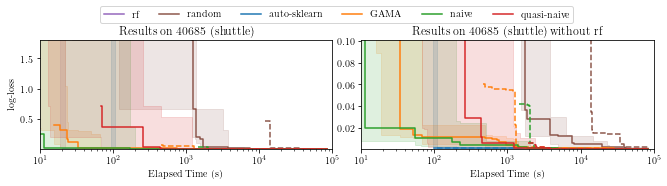

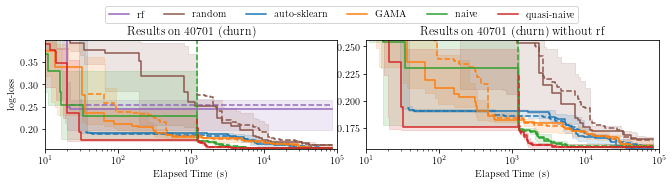

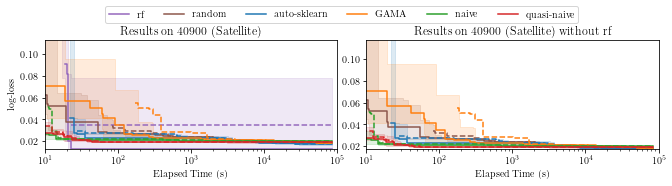

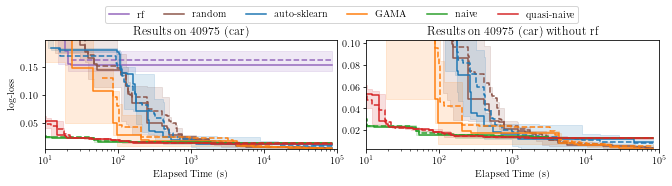

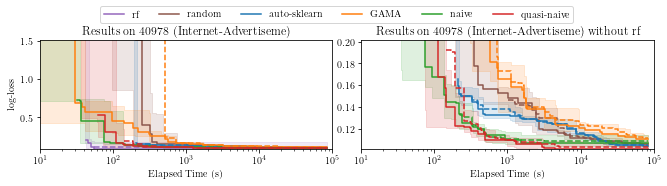

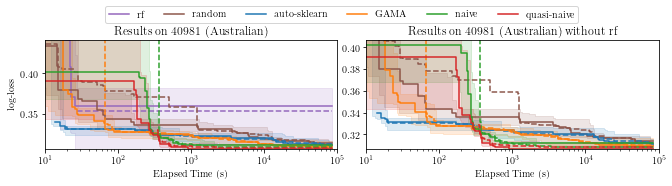

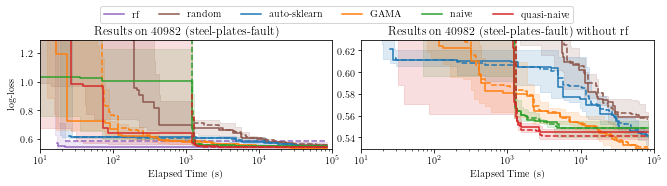

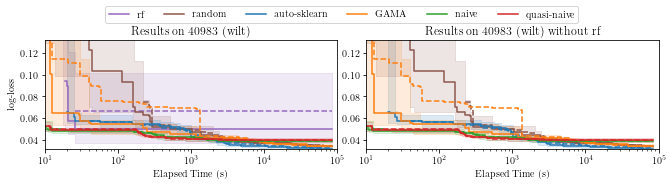

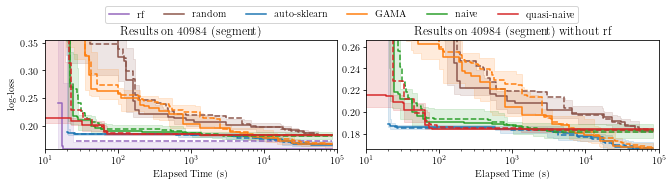

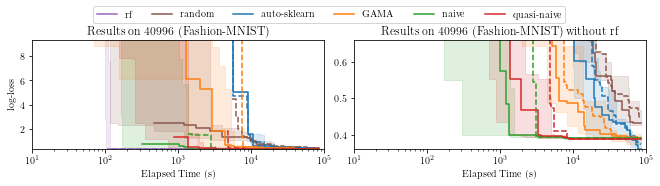

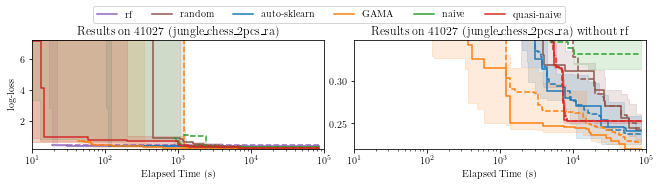

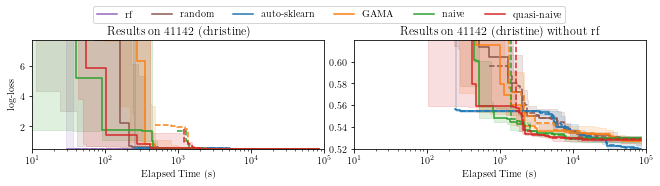

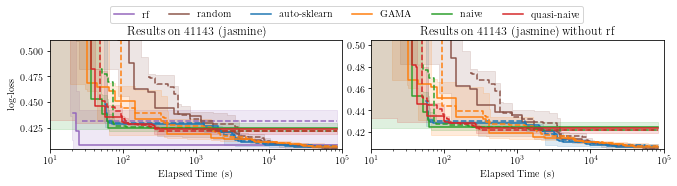

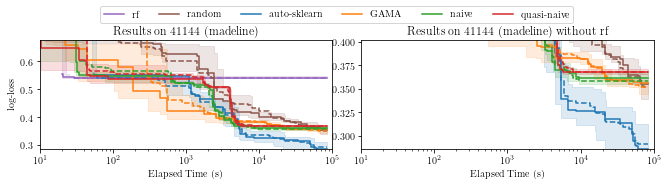

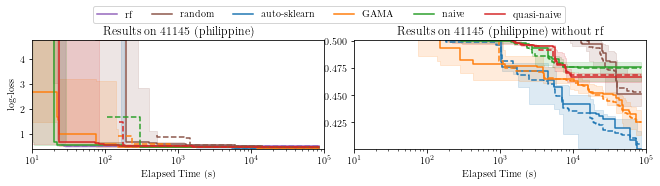

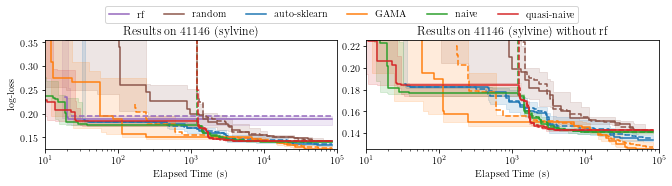

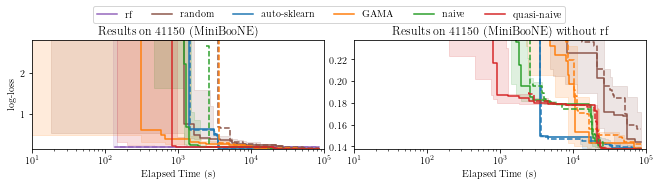

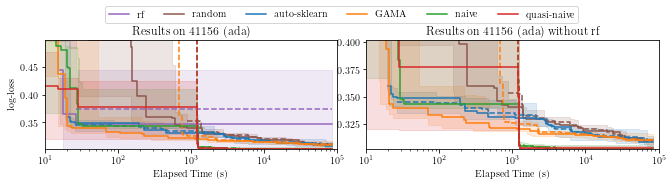

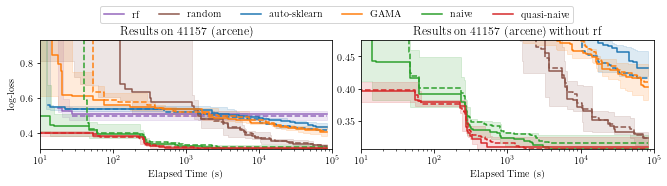

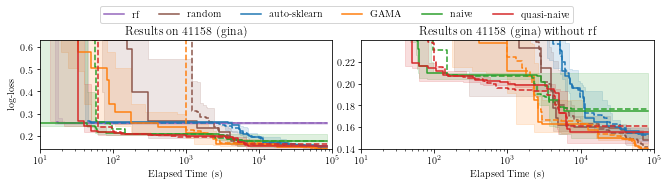

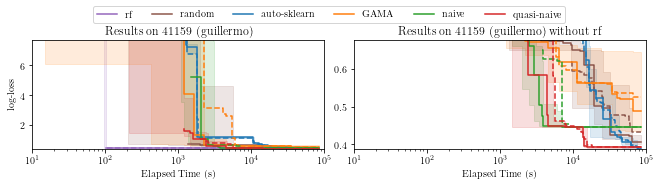

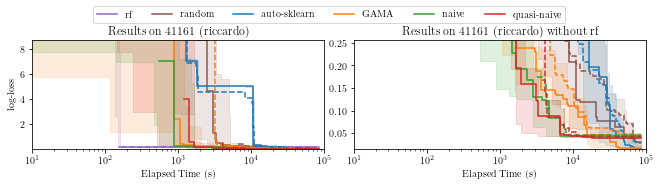

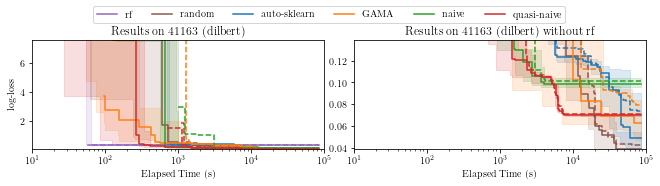

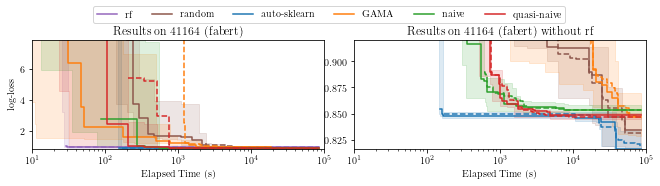

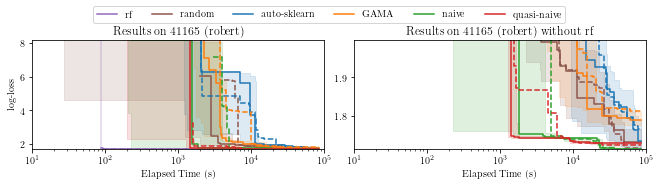

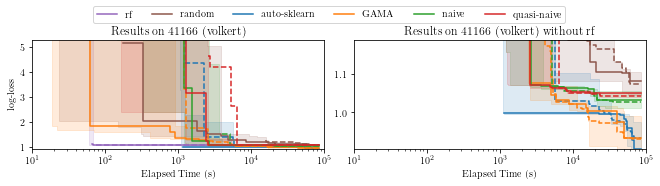

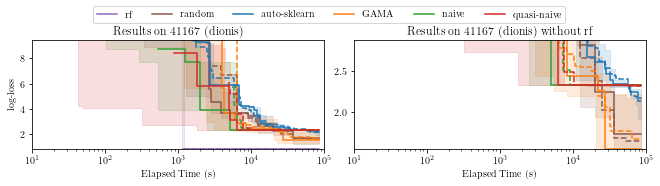

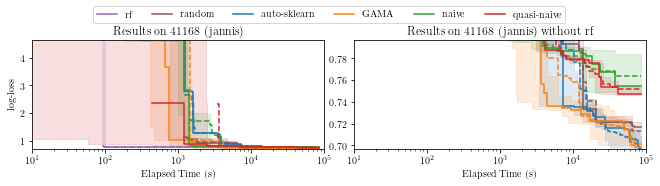

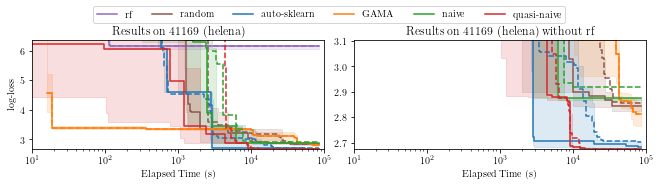

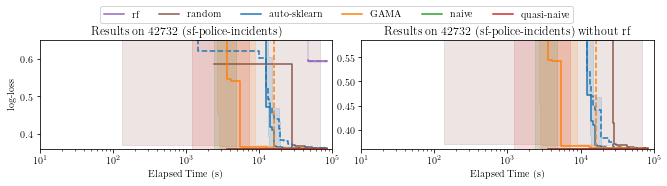

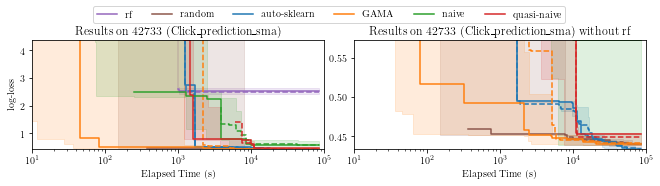

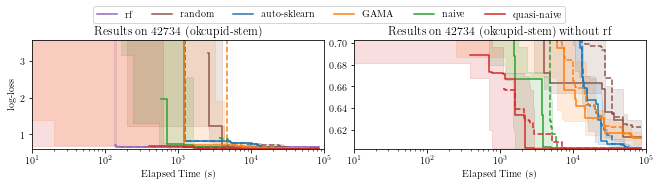

In [48]:
for openmlid in sorted(datasets):
    
    if not openmlid in performance_curves_1d:
        print(f"No information for openmlid {openmlid}")
        continue
    
    fig, (ax_1d, ax_no_rf) = plt.subplots(1, 2, figsize=(11, 2))
    plot_performances_over_time({openmlid: performance_curves_1d[openmlid]}, "1d", algorithm_order=OPTIMIZERS, focus="start", ax=ax_1d)
    plot_performances_over_time({openmlid: {algo: performance_curves_1d[openmlid][algo] for algo in OPTIMIZERS if algo != "rf"}}, "1d", algorithm_order=[o for o in OPTIMIZERS if o != "rf"], focus="end", ax=ax_no_rf)

    ax_1d.set_title("Results on " + str(openmlid) + " (" + datasetnames[openmlid][:20].replace("_", "\\_") + ")")
    ax_no_rf.set_title("Results on " + str(openmlid) + " (" + datasetnames[openmlid][:20].replace("_", "\\_") + ") without rf")
    ax_1d.set_ylabel("log-loss")
    
    for a in [ax_1d, ax_no_rf]:
        a.set_xlabel("Elapsed Time (s)")
        a.set_xscale("log")
        a.set_xlim([10, 100000])
    fig.subplots_adjust(wspace=.1)
    handles, labels = ax_1d.get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=6)
    fig.savefig("plots/runs/" + str(openmlid) + ".pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()

In [46]:
latex = ""
i = 0
n = 6
for openmlid in sorted(datasets):
    print("\\includegraphics[width=\\textwidth]{"+ str(openmlid) + ".pdf}\\\\[-.5em]")

\includegraphics[width=\textwidth]{3.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{12.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{23.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{31.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{54.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{181.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1049.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1067.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1457.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1461.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1464.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1468.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1475.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1485.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1486.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1487.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1489.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1494.pdf}\\[-.5em]
\includegraphics[width=\textwidth]{1515.

## Detailed Result Table

In [41]:
def getResultTable(dfResults, rowAttribute, colAttribute, resultAttribute, col_labels = None, cellFormatter = None, comparativeFormatters = None, row_formatter = None, colnames = None):
    rows = []
    if colnames is None:
        colnames = list(pd.unique(dfResults[colAttribute]))
    for rowIndex, dfRow in dfResults.groupby(rowAttribute):
        
        # identify all scores for row
        scores = {}
        for colName in colnames:
            if colName != rowAttribute:
                scoresForCell = dfRow[(dfRow[colAttribute] == colName) & (dfRow[resultAttribute].notna())][resultAttribute].values
                if len(scoresForCell) == 0:
                    scoresForCell = [np.nan]
                scores[colName] = sorted(scoresForCell)
        
        rows.append([rowIndex] + row_formatter(rowIndex, scores))
    
    with pd.option_context("max_colwidth", 1000):
        return pd.DataFrame(rows, columns=[rowAttribute] + [col_labels[col] if not col_labels is None and col in col_labels else col for col in colnames])

In [42]:
def get_default_best_formatting(scores, indices, is_minimize, relevance_gap):
    cellFormatter = lambda x: str(np.round(scipy.stats.trim_mean(x, 0.1), 2)) + "$\pm$" + str(np.round(np.nanstd(x), 2)) if len([y for y in x if not np.isnan(y)]) > 0 else "nan"
    
    # get best score (and column name)
    bestMean = None
    bestCol = None
    for colName in scores:
        scoresForCell = scores[colName]
        meanScore = scipy.stats.trim_mean(scoresForCell, 0.1)
        if ~np.isnan(meanScore) and (bestCol is None or (is_minimize and bestMean > meanScore or not is_minimize and bestMean < meanScore)):
            bestMean = meanScore
            bestCol = colName
    
    # now apply formatters to cells and add them to row
    bestScores = scores[bestCol] if not bestCol is None else []
    
    # formatting of best cells
    row = []
    if bestMean is None:
        for colName in indices:
            row.append("nan")
    else:
        for colName in indices:
            scoresForCell = scores[colName]
            curMean = scipy.stats.trim_mean(scoresForCell, 0.1)
            isBest = ((bestCol == colName) | (np.round(curMean, 2) == np.round(bestMean, 2)))
            if not isBest:
                n = min(len(bestScores), len(scoresForCell))
                if n > 0:
                    if n > 1:
                        wilcoxon = sp.stats.wilcoxon(bestScores[:n], scoresForCell[:n])
                        isSignificant = wilcoxon.pvalue < 0.05
                        isRelevant = np.round(np.abs(np.round(bestMean, 2) - np.round(curMean, 2)), 2) > relevance_gap
                    else:
                        isSignificant = False
                        isRelevant = False
                else:
                    isSignificant = True
                    isRelevant = True
            entry = cellFormatter(scoresForCell)
            if isBest:
                entry = "\\textbf{" + str(entry) + "}"
            elif entry != "nan" and not (isSignificant and isRelevant):
                entry = "\\underline{" + str(entry) + "}"
            row.append(entry)
    return row

def get_row_layouter(is_minimize, relevance_gap):

    def row_layouter(openmlid, scores):

        indices = [x for x in scores]
        row = get_default_best_formatting(scores, indices, is_minimize, relevance_gap)

        '''
        # we now have one (formatted) entry for each column. Now add bullet/circ symbols
        naive_cols = [x for x in scores if "naive" in x]
        competitor_cols = [x for x in scores if not "naive" in x]
        for naive_col in naive_cols:
            scores_naive = scores[naive_col]
            mean_naive = np.round(scipy.stats.trim_mean(scores_naive, 0.1), 2)
            for competitor_col in competitor_cols:
                scores_competitor = scores[competitor_col]
                mean_competitor = np.round(scipy.stats.trim_mean(scores_competitor, 0.1), 2)
                n = min(len(scores_naive), len(scores_competitor))
                if n > 1 and scores_naive[:n] != scores_competitor[:n]:
                    wilcoxon = sp.stats.wilcoxon(scores_naive[:n], scores_competitor[:n])
                    isSignificant = wilcoxon.pvalue < 0.05
                else:
                    isSignificant = False

                diff = np.round(mean_competitor - mean_naive, 2)

                is_substantially_better = isSignificant and ((is_minimize and diff > 0.01) or (not is_minimize and diff < -0.01))
                is_substantially_worse = isSignificant and ((is_minimize and diff < -0.01) or (not is_minimize and diff > 0.01))
                i = indices.index(competitor_col)
                if is_substantially_worse:
                    row[i] += " $\\circ$"
                elif is_substantially_better:
                    row[i] += " $\\bullet$"

                else:
                    row[i] += " \\phantom{$\\circ$}"
        '''
        return row

    return row_layouter


latex_colname_map = {
    "openmlid": "id"
}

In [43]:
dfResultsFinalPython = getResultTable(dfResults[(dfResults["timeout"] == 85000) & (dfResults["openmlid"].isin(datasets_logloss))], "openmlid", "algorithm", "metric", col_labels=OPTIMIZER_NAMES, row_formatter=get_row_layouter(True, 0.1), colnames=OPTIMIZERS)
with pd.option_context("max_colwidth", 1000):
    dfMerge = dfResultsFinalPython.rename(columns=latex_colname_map)
    latex_colname_map_centered = {}
    for col in dfMerge.columns:
        latex_colname_map_centered[col] = "\\multicolumn{1}{c}{" + col + "}"
    dfMerge = dfMerge.rename(columns=latex_colname_map_centered)
    str_base_table = dfMerge.to_latex(index=False, escape=False)
    print(str_base_table.replace("{rllll}", "{r||rrrr}"))

\begin{tabular}{rllllll}
\toprule
 \multicolumn{1}{c}{id} &     \multicolumn{1}{c}{rf} & \multicolumn{1}{c}{random} & \multicolumn{1}{c}{auto-sklearn} &   \multicolumn{1}{c}{GAMA} &  \multicolumn{1}{c}{naive} & \multicolumn{1}{c}{quasi-naive} \\
\midrule
                      3 &   \underline{0.05$\pm$0.0} &      \textbf{0.01$\pm$0.0} &            \textbf{0.01$\pm$0.0} &     \textbf{0.01$\pm$0.01} &  \underline{0.02$\pm$0.03} &          \textbf{0.01$\pm$0.01} \\
                     12 &  \underline{0.26$\pm$0.06} &  \underline{0.11$\pm$0.05} &        \underline{0.11$\pm$0.04} &      \textbf{0.1$\pm$0.04} &  \underline{2.75$\pm$4.11} &       \underline{0.48$\pm$0.72} \\
                     23 &              1.45$\pm$0.24 &   \underline{0.9$\pm$0.06} &           \textbf{0.89$\pm$0.05} &   \underline{0.9$\pm$0.03} &               1.0$\pm$0.06 &       \underline{0.92$\pm$0.06} \\
                     31 &  \underline{0.56$\pm$0.12} &     \textbf{0.52$\pm$0.05} &        \underline{0.53$\p